# VE mobile default test buckets analysis

Druing [initial check](https://phabricator.wikimedia.org/T229426#5468481), we uncovered, "...53.4% of the users (both registered and anonymous) who were bucketed ended up in wikitext default bucket. It turns out that it would be incredibly unlikely (p << 10^-15) to get an imbalance this big if our random assignment was actually 50%–50%. So there's clearly an serious issue somewhere that we need to understand."

**Previous bucketing results:**

| bucket         | users     |
|:---------------|-----------|
| source default | 1,302,187 |
| visual default | 1,214,917 |



## Plan for investigation

What might be causing contributors not being assigned to test buckets in a more balanced way?
1. See if imblance is present for any particular dimension. 
  + Registered vs anonymous contributors
  + Country
  + Browser
  + Wiki
  + Event.action (to confirm that imblance occurs at first action and throughout editing process)
2. Report results back to team to determine what next steps make sense.


In [58]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate)
    library(scales); library(data.table)
})


## Collect Data

In [92]:
query <- 
"
SELECT
    event.editing_session_id as edit_attempt_id, 
    wiki,  
    event.platform as platform, 
    useragent.browser_family as browser_family, 
    useragent.os_family as os_family, 
    event.editor_interface as interface, 
    if(event.user_id != 0, concat(wiki, '-', event.user_id), event.anonymous_user_token) as user_id,
    event.user_id = 0 as user_is_anonymous_byid, 
    if(event.anonymous_user_token is NULL, false, true) as user_is_anonymous_bytoken, 
    event.user_id != 0 as user_is_registered, 
    event.action as action,
    event.init_timing as init_timing,
    event.bucket,  
    geocoded_data['country'] as country,
    event.user_editcount as user_edit_count
FROM event.editattemptstep
WHERE
    event.bucket in ('default-visual', 'default-source') and
    year = 2019 and (
        month = 7 and day >= 14 or
        month >= 8)
"


In [93]:
sessions = wmf::query_hive(query)

In [96]:
#recheck overall user bucket number to confirm any changes imbalance 

sessions_all <- sessions %>%
  group_by(bucket) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id))

sessions_all

bucket,users,attempts
<chr>,<int>,<int>
default-source,1907187,2721255
default-visual,1784439,2539846


Confirmed that a larger percentage of users (about 51.6%) are still being included in the wikitext as default bucket.

## Check if imbalance is present for just registered or anonymous users.

In [19]:
## Break down by anonymous users to identify any discrepancy that occurs there

sessions_anonymous <- sessions %>%
  filter(user_is_anonymous_byid == 'true') %>%
  group_by(bucket) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id))

sessions_anonymous

bucket,users,attempts
<chr>,<int>,<int>
default-source,1891449,2663795
default-visual,1769443,2482893


We also see an imbalance when looking at just anonymous users. About 51.7% of users are included in the wikitext as default bucket, similar to when looking at all users.

In [20]:
## Look at user_isanonymous_bytoken to confirm it matches with user_is_anonymous_byid

sessions_anonymous_bytoken <- sessions %>%
  filter(user_is_anonymous_bytoken == "true") %>%
  group_by(bucket) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id))

sessions_anonymous_bytoken

bucket,users,attempts
<chr>,<int>,<int>
default-source,1891449,2663795
default-visual,1769443,2482893


Confirmed those two are equal. 

In [24]:
## Break down by registered users to identify any discrepancy that occurs there

sessions_registered <- sessions %>%
  filter(user_is_registered == "true") %>%
  group_by(bucket) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id))

sessions_registered

bucket,users,attempts
<chr>,<int>,<int>
default-source,9137,47809
default-visual,8819,47925


Unable to isolate imbalance to just anonymous or registred users. 

We also see an imbalance when looking at just anonymous users or registered users. About 51.7% of anonymous users and 50.9% of registered users are included in the wikitext as default bucket, similar to when looking at all users.

## Check if imblance is present for a particular browser.

In [70]:
sessions_bybrowser <- sessions %>%
  group_by(bucket, browser_family) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
  arrange(browser_family)

head(sessions_bybrowser)

bucket,browser_family,users,attempts
<chr>,<chr>,<int>,<int>
default-source,Amazon Silk,262,395
default-visual,Amazon Silk,280,402
default-source,Android,4667,6604
default-visual,Android,3887,6178
default-source,Baidu Browser,1,1
default-source,bingbot,398,689


In [74]:
sessions_bybrowser$users <- as.numeric(sessions_bybrowser$users)
sessions_bybrowser$attempts <- as.numeric(sessions_bybrowser$attempts)

In [75]:
sessions_bybrowser$bucket[sessions_bybrowser$bucket == "default-source"] <- "default_source"
sessions_bybrowser$bucket[sessions_bybrowser$bucket == "default-visual"] <- "default_visual"


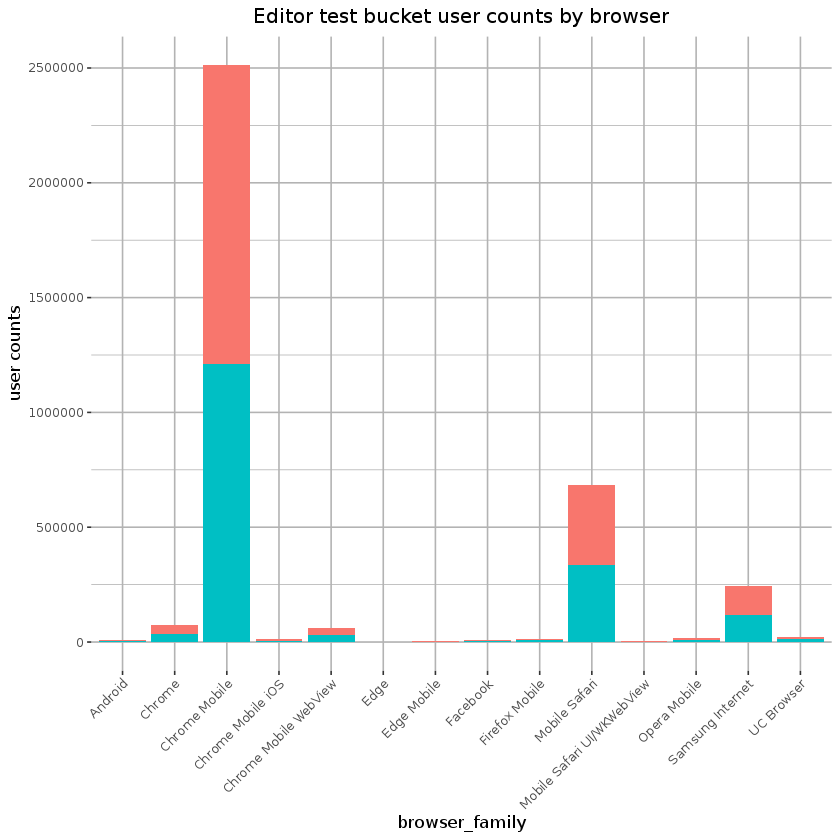

In [33]:
# Look at test bucket user counts for top browsers 
sessions_bybrowser_plot <- sessions_bybrowser %>%
  filter(browser_family %in% c('Chrome Mobile', 'Mobile Safari', 'Samsung Internet', 'Chrome', 
                              'Chrome Mobile WebView', 'UC Browser', 'Opera Mobile', 'Firefox Mobile',
                              'Chrome Mobile iOS', 'Facebook', 'Android', 'Mobile Safari UI/WKWebView',
                              'Edge Mobile', 'Edge')) %>% # filter to top browsers for plot visibility
  ggplot(aes(x= browser_family, y = users, fill = bucket)) +
  geom_col() +
   scale_y_continuous("user counts") +
    labs(title = "Editor test bucket user counts by browser") +
    ggthemes::theme_tufte(base_size = 10, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position= "none")


sessions_bybrowser_plot

For the major browser types, there is a similar imbalance.

In [102]:
sessions_bybrowser_percent_imbalance <- sessions_bybrowser %>%
 select(-4)  %>% ##look at user counts only
 spread(bucket,users) %>% 
 #mutate(percent_diff = round(abs((default_source-default_visual)/default_visual *100), 3)) %>%
 mutate(percent_wikitext_users = default_source/(default_source + default_visual) *100) %>%
 arrange(desc(percent_wikitext_users)) 

head(sessions_bybrowser_percent_imbalance)

browser_family,default_source,default_visual,percent_wikitext_users
<chr>,<dbl>,<dbl>,<dbl>
bingbot,398,2,99.50000
BingPreview,377,7,98.17708
NetFront NX,18,1,94.73684
Chromium,7,1,87.50000
oBot,3,1,75.00000
Vivaldi,3,1,75.00000


We do notice some much larger differences in buckets for the smaller browsers. Some of these are just due to the smaller population of overall users; however, there seems to be a signficant difference seeen for Bingbot and BingPreview browsers. These are both web crawling bot browsers, which might be a clue into what is occuring.

## Check if imbalance is present for a particular country

In [103]:
sessions_bycountry <- sessions %>%
  group_by(bucket, country) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
  arrange(country, users) 

head(sessions_bycountry)

bucket,country,users,attempts
<chr>,<chr>,<int>,<int>
default-visual,Afghanistan,53,72
default-source,Afghanistan,56,65
default-visual,Åland,221,284
default-source,Åland,239,313
default-visual,Albania,810,1073
default-source,Albania,871,1145


Unable to isolate to a specific country. A large number of users for each country (around 51%) are added to the wikitext as default bucket.

There is an imbalance across all countries as well with a higher percentage of users added to the wikitext editor as default. bucket

## Check if imbalance is present for a particular wiki

In [88]:

sessions_bywiki <- sessions %>%
  group_by(bucket, wiki) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
  arrange(wiki) 

sessions_bywiki

bucket,wiki,users,attempts
<chr>,<chr>,<int>,<int>
default-source,azwiki,30959,45825
default-visual,azwiki,27084,39485
default-source,bgwiki,36032,54248
default-visual,bgwiki,34397,50781
default-source,cawiki,17405,23624
default-visual,cawiki,16698,22615
default-source,dawiki,40500,51981
default-visual,dawiki,38869,49837
default-source,elwiki,70126,104277


In [89]:
sessions_bywiki$users <- as.numeric(sessions_bywiki$users)
sessions_bywiki$attempts <- as.numeric(sessions_bywiki$attempts)

In [90]:
sessions_bywiki$bucket[sessions_bywiki$bucket == "default-source"] <- "default_source"
sessions_bywiki$bucket[sessions_bywiki$bucket == "default-visual"] <- "default_visual"

In [91]:
sessions_bywiki_percent_imbalance <- sessions_bywiki %>%
 select(-4)  %>% ##look at user counts only
 spread(bucket,users) %>% 
 #mutate(percent_diff = round(abs((default_source-default_visual)/default_visual *100), 3)) %>%
 mutate(percent_wikitext_users = default_source/(default_source + default_visual) *100) %>%
 arrange(desc(percent_wikitext_users)) 

head(sessions_bywiki_percent_imbalance)

wiki,default_source,default_visual,percent_wikitext_users
<chr>,<dbl>,<dbl>,<dbl>
azwiki,30959,27084,53.33804
urwiki,10885,9567,53.22218
mlwiki,42919,37837,53.14652
thwiki,250324,226800,52.46519
mswiki,71688,65501,52.25492
tawiki,82113,76366,51.81317


In [ ]:
Unable to isolate the imblance to a particular wiki. Similar imblance trends seen.

## Check if imbalance is present for a particular action

Based on earlier result, we should see an imblance across all actions as well but just want to confirm.  

In [95]:
sessions_byaction <- sessions %>%
  group_by(bucket, action) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
  arrange(action) 

sessions_byaction

bucket,action,users,attempts
<chr>,<chr>,<int>,<int>
default-source,abort,1387151,1763603
default-visual,abort,835965,998167
default-source,init,1906751,2720469
default-visual,init,1784041,2539217
default-source,loaded,1903903,2708243
default-visual,loaded,1256521,1708057
default-source,ready,1904072,2708547
default-visual,ready,1256752,1708386
default-source,saveAttempt,32690,88018


Confirmed. There is an imbalance across all actions as well ranging from about 51% to 54%.

## Summary of Initial Findings

1. Unable to isolate the imbalance to one of the following subgroups  (user group (registered or anonymous), country, wiki or event action). Across all these groups, there were a similar imbalance between the wikitext and visual editor buckets  with higher number of users (around 51 to 54%) being placed in the wikitext bucket. 
2. These was also a similar imbalance across all of the major browsers; however, there seems to be a signficant difference between the wikitext and visual editor buckets for Bingbot and BingPreview browsers. For Bingbot, about 98% of 384 users were placed in the wikitext ad default bucket. These are both web crawling bot browsers. This imbalance wouldn't account for the total imbalance we are seeing in overall users but it might be a clue into where the issue is happening. 
3.   Since we're seeing the same imbalance towards the wikitext buckets across these various dimensions, it seems likely that this might be either a load time issue or an issue with the method of bucket assigment. 

Potential areas to investigate further: load time issue?
Can we confirm that both buckets assigned on the server side?  Are they assigned at the same time an init event is recorded on the server? If for some reason, wikitext bucket is assigned on the server side and visual editor on the client side, than that delay might be why we are seeing fewing people in the visual editor buckets.

